# Proyecto práctico (Regresión)

In [1]:
# --- LIBRERÍAS ---
import pandas as pd  # Para manipulación de datos
import numpy as np  # Para operaciones numéricas
import matplotlib.pyplot as plt  # Para visualización de gráficos
import seaborn as sns  # Para visualizaciones estadísticas
import pickle  # Para guardar modelos en disco
from sklearn.model_selection import KFold, cross_val_predict  # Validación cruzada
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  # Preprocesamiento
from sklearn.linear_model import LinearRegression  # Modelo de regresión lineal
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error  # Métricas de evaluación
from math import sqrt  # Para calcular la raíz cuadrada

In [2]:
# --- 1. CARGA DE DATOS ---
# Cargar el dataset desde la URL oficial del repositorio UCI
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
df = pd.read_csv(url, sep=';')  # Leer CSV con separador punto y coma

# Mostrar dimensiones del dataset
print(f"El dataset tiene {df.shape[0]} filas y {df.shape[1]} columnas.")

El dataset tiene 4898 filas y 12 columnas.



Primeras filas del dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5   

C:\Users\AdrianGilGamboa\AppData\Local\Temp\ipykernel_19824\4021572532.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df, palette='crest')


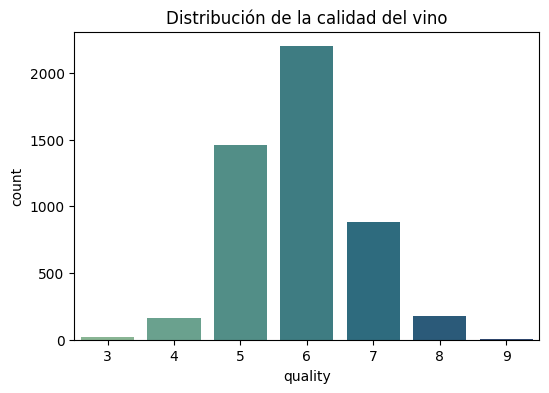

In [3]:
# --- 2. ANÁLISIS EXPLORATORIO ---
print("\nPrimeras filas del dataset:")
print(df.head())  # Mostrar primeras 5 filas

print("\nDistribución de la variable objetivo:")
print(df['quality'].value_counts().sort_index())  # Ver distribución de la variable target (quality)

# Gráfico de distribución de la variable objetivo
plt.figure(figsize=(6, 4))
sns.countplot(x='quality', data=df, palette='crest')
plt.title("Distribución de la calidad del vino")
plt.show()

In [4]:
# --- 3. PREPROCESAMIENTO ---
X = df.drop('quality', axis=1).values  # Variables independientes
y = df['quality'].values  # Variable dependiente

# Escalado de características para igualar la magnitud de las variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Generación de características polinómicas de segundo grado
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

In [5]:
# --- 4. MODELO Y VALIDACIÓN CRUZADA ---
model = LinearRegression()  # Instanciar modelo de regresión lineal
cv = KFold(n_splits=5, shuffle=True, random_state=42)  # Validación cruzada K-Fold (5 particiones)

# Obtener predicciones cruzadas (para todo el dataset)
y_pred = cross_val_predict(model, X_poly, y, cv=cv)

# Listas para guardar métricas por cada fold
rmse_scores = []
mape_scores = []

print("\nEvaluación por fold (5-fold cross-validation):")
# Bucle para entrenar y evaluar por cada fold
for fold, (train_idx, test_idx) in enumerate(cv.split(X_poly)):
    X_train, X_test = X_poly[train_idx], X_poly[test_idx]  # División de datos
    y_train, y_test = y[train_idx], y[test_idx]
    
    model.fit(X_train, y_train)  # Entrenar modelo en los datos de entrenamiento
    y_pred_fold = model.predict(X_test)  # Predecir valores sobre el fold de prueba
    
    # Calcular métricas
    rmse = sqrt(mean_squared_error(y_test, y_pred_fold))  # Raíz del error cuadrático medio
    mape = mean_absolute_percentage_error(y_test, y_pred_fold) * 100  # Error porcentual absoluto medio
    
    rmse_scores.append(rmse)
    mape_scores.append(mape)
    
    print(f"Fold {fold+1}: RMSE = {rmse:.3f}, MAPE = {mape:.2f}%")

# Promedios finales de las métricas
print(f"\nRMSE medio: {np.mean(rmse_scores):.3f}")
print(f"MAPE medio: {np.mean(mape_scores):.2f}%")


Evaluación por fold (5-fold cross-validation):
Fold 1: RMSE = 0.787, MAPE = 10.10%
Fold 2: RMSE = 0.701, MAPE = 9.58%
Fold 3: RMSE = 0.728, MAPE = 10.03%
Fold 4: RMSE = 0.701, MAPE = 9.60%
Fold 5: RMSE = 0.744, MAPE = 10.12%

RMSE medio: 0.732
MAPE medio: 9.88%


In [6]:
# --- 5. ENTRENAMIENTO FINAL Y GUARDADO ---
modelo_final = LinearRegression()  # Instanciar modelo final
modelo_final.fit(X_poly, y)  # Entrenar modelo con todos los datos

# Guardar únicamente el modelo entrenado
with open('modelo_regresion_polinomica.pkl', 'wb') as f:
    pickle.dump(modelo_final, f)

print("\nModelo de regresión polinómica guardado.")


Modelo de regresión polinómica guardado.


In [7]:
# --- 6. TABLA DE VALORES REALES vs PREDICHOS ---
# Predecir con el modelo final sobre todo el conjunto
y_pred_final = modelo_final.predict(X_poly)

# Crear DataFrame con los resultados
df_resultados = pd.DataFrame({
    'Real': y,
    'Predicho': np.round(y_pred_final, 2)  # Redondear para mejor visualización
})

# Mostrar todas las filas del DataFrame
#pd.set_option('display.max_rows', None)  # Elimina límite de filas visibles
print("\nComparación entre valores reales y predichos:")
print(df_resultados)


Comparación entre valores reales y predichos:
      Real  Predicho
0        6      5.73
1        6      5.14
2        6      5.88
3        6      5.87
4        6      5.87
...    ...       ...
4893     6      6.08
4894     5      5.65
4895     6      5.37
4896     7      6.66
4897     6      6.34

[4898 rows x 2 columns]
